In [1]:
########### LIBRARIES ##########
import numpy as np
from numpy.random import default_rng
from numpy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt
from matplotlib import rcParams
%pylab inline

rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [7, 6]

from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split

from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras import optimizers
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K

from sklearn.preprocessing import MinMaxScaler

import os
from scipy.io import loadmat,savemat

Populating the interactive namespace from numpy and matplotlib


C:\Users\paolo\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
train = False
save = False
create_data = False

seed = 100

### Load the data
You must run *KuraSiva.ipynb* in order to generate the dataset

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/264955316.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, u, cmap='inferno', rasterized=True)


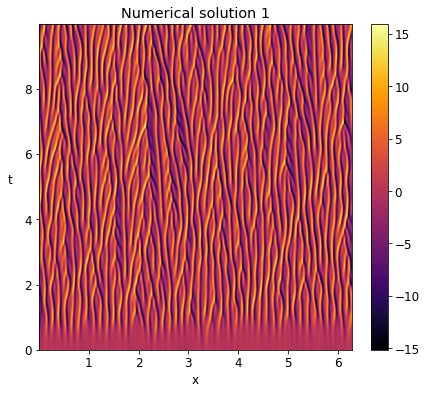

In [3]:
KS_data = loadmat('KS_data.mat')
u = KS_data['uu']
x = KS_data['x'].flatten()
t = KS_data['t'].flatten()

dt = t[1] - t[0]
dx = x[2] - x[1]

n = len(x)
m = len(t)

#Plot
fig = plt.figure()
X, T = np.meshgrid(x, t)
im = plt.pcolor(X, T, u, cmap='inferno', rasterized=True)
plt.xlabel('x')
plt.title('Numerical solution 1')
plt.ylabel('t', rotation = 0, labelpad = 15)
fig.colorbar(im)
#plt.savefig('./images/KS_sol_1.pdf',bbox_inches='tight', pad_inches=0.1)ù
plt.show()

### Builid and train the NN model

In [4]:
#Prepare data to feed the NN
nn_input = u[0:-1,:]
nn_output = u[1:,:]

In [5]:
# Set seed for reproducibility
np.random.seed(seed)
x_train, x_valid, y_train, y_valid = train_test_split(nn_input, nn_output, test_size = 0.2)

# Build model
nn_model = keras.models.Sequential()
nn_model.add(layers.Dense(2048, input_dim=2048, activation='tanh'))
nn_model.add(layers.Dense(1024, activation='tanh'))
nn_model.add(layers.Dense(2048, activation='linear'))

# Compile model
opt = keras.optimizers.Adam(learning_rate=0.01)
nn_model.compile(loss='mse', optimizer=opt)

# Fit!
if train:
    tf.random.set_seed(seed)
    History = nn_model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_data=(x_valid, y_valid), callbacks=keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights= True))
else:
    json_file = open("./models/nn_KS.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    nn_model.load_weights("./models/nn_KS.h5")
    print("Loaded model from disk")

if save:
    model_json = nn_model.to_json()
    with open("./models/nn_KS.json", "w") as json_file:
        json_file.write(model_json)
    nn_model.save_weights("./models/nn_KS.h5")
    print("Saved model to disk")

Loaded model from disk


## Approach I: Advance solution from $t$ to $t + \Delta t$

In [6]:
#Predict
u_pred = nn_model.predict(nn_input)

print('mse: ', np.mean(np.square(u_pred - nn_output)))

mse:  0.11836851413221217


C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/323338836.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/323338836.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, u_pred, cmap='inferno', rasterized=True)


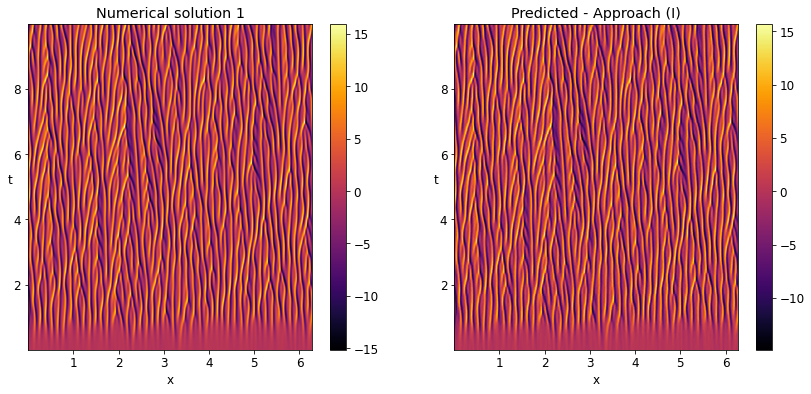

In [7]:
fig = plt.figure(figsize = [14,6])
X, T = np.meshgrid(x, t[1:])

subplot(1,2,1)
plt.title('Numerical solution 1')
im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)

subplot(1,2,2)
plt.title('Predicted - Approach (I)')
im = plt.pcolor(X, T, u_pred, cmap='inferno', rasterized=True)
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)
plt.show()

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/133574039.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, T, np.abs(nn_output - u_pred) , cmap='bwr', rasterized=True)


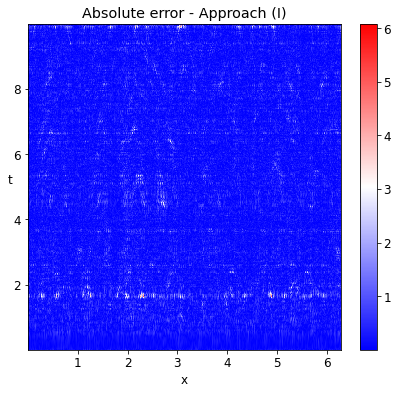

In [8]:
#Plot absolute error
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t[1:])
plt.title('Absolute error - Approach (I)')
im = ax.pcolormesh(X, T, np.abs(nn_output - u_pred) , cmap='bwr', rasterized=True)
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)
plt.show()

## Approach II (recursive): Advance solution from $t$ to $t + \Delta t$

In [9]:
u_pred_rec = np.zeros(shape = (m,n))
u_pred_rec[0,:] = nn_input[0,:]
for i in range(1,m):
    u_pred_rec[i,:] = nn_model.predict(u_pred_rec[i-1,:].reshape(1,-1))
u_pred_rec = u_pred_rec[1:,:]

print('mse: ', np.mean(np.square(u_pred_rec - nn_output)))

mse:  61.96323669740392


C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/3700803737.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/3700803737.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, u_pred_rec, cmap='inferno', rasterized=True)


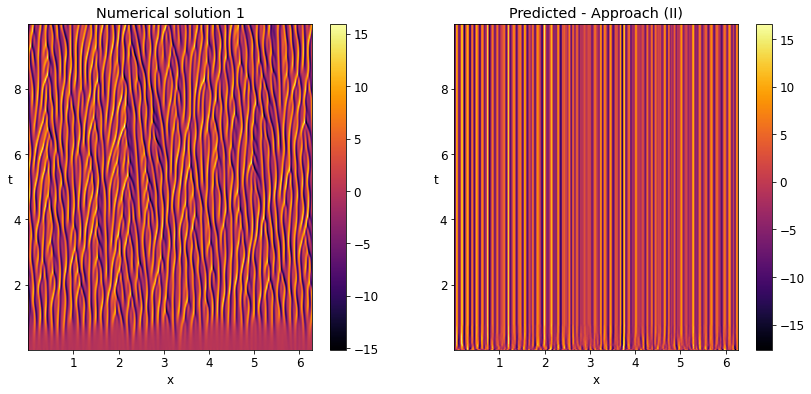

In [10]:
fig = plt.figure(figsize = [14,6])
X, T = np.meshgrid(x, t[1:])

subplot(1,2,1)
im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
plt.title('Numerical solution 1')
fig.colorbar(im)

subplot(1,2,2)
im = plt.pcolor(X, T, u_pred_rec, cmap='inferno', rasterized=True)
plt.title('Predicted - Approach (II)')
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)
plt.show()

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/2922208013.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, T, np.abs(nn_output - u_pred_rec) , cmap='bwr', rasterized=True)


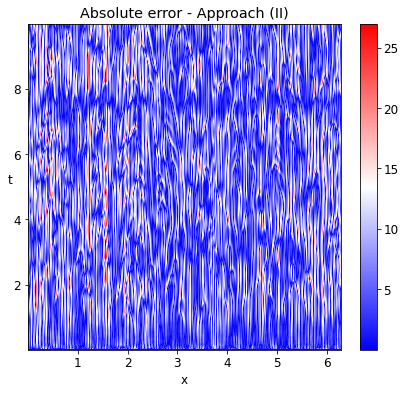

In [11]:
#Plot absolute error
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t[1:])
plt.title('Absolute error - Approach (II)')
im = ax.pcolormesh(X, T, np.abs(nn_output - u_pred_rec) , cmap='bwr', rasterized=True)
plt.xlabel('x')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)
plt.show()

## Test NN model on new initial condition

#### Generate test data

In [12]:
n_ic_test = 100

if create_data: 
    N = 2048
    x = (2*np.pi*np.arange(1,N+1)/N)
    nu = 0.05

    # spatial grid and initial conditions
    h = 0.01
    k = (np.r_[np.arange(0, N/2), np.array([0]), np.arange(-N/2+1, 0)]/16).astype('float64')
    L = k**2 - nu*k**4
    exp1 = np.exp(h*L)
    exp2 = np.exp(h*L/2)
    M = 16
    r = np.exp(1j*np.pi*(np.arange(1, M+1)-0.5) / M)
    LR = h*np.repeat([L], M, axis=0).T + np.repeat([r], N, axis=0)
    Q = h*np.real(np.mean((np.exp(LR/2)-1)/LR, axis=1))
    f1 = h*np.real(np.mean((-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1))
    f2 = h*np.real(np.mean((2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1))
    f3 = h*np.real(np.mean((-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1))

    tmax = 10
    step_max = round(tmax/h)
    step_plt = int(tmax/(1000*h))
    g = -0.5j*k
    u_final = np.zeros(shape = (n_ic_test*step_max,N))

    for i in range(n_ic_test):
        print(i)
        rng = default_rng(i)
        u = rng.standard_normal(N).astype('float64')
        v = fft(u)

        uu = np.array([u])
        tt = 0

        for step in range(1, step_max):
            t = step*h
            Nv = g*fft(np.real(ifft(v))**2)
            a = exp2*v + Q*Nv
            Na = g*fft(np.real(ifft(a))**2)
            b = exp2*v + Q*Na
            Nb = g*fft(np.real(ifft(b))**2)
            c = exp2*a + Q*(2*Nb - Nv)
            Nc = g*fft(np.real(ifft(c))**2)
            v = exp1*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3
            if step % step_plt == 0:
                u = np.real(ifft(v))
                uu = np.append(uu, np.array([u]), axis=0)
                tt = np.hstack((tt, t))
                # uu[:,step] = u
                # tt[step] = t

        u_final[i*step_max:(i+1)*step_max,:] = uu
        
    print('save data') 
    savemat('KS_data_full.mat',{'u_final' : u_final})
else:
    print('Load data') 
    u_final = loadmat('KS_data_full.mat')['u_final']

Load data


#### Just show the results for one new initial condition

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/2834293361.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, T, u_final[i_test*m:(i_test+1)*(m-1),:], cmap='inferno', rasterized=True)


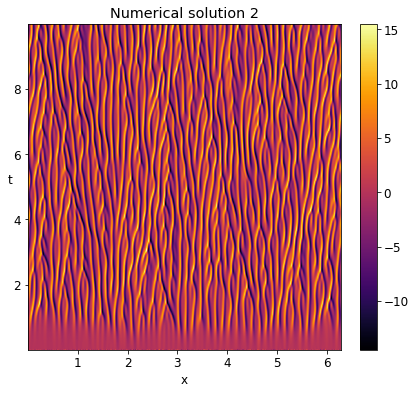

In [13]:
i_test = 1

fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(X, T, u_final[i_test*m:(i_test+1)*(m-1),:], cmap='inferno', rasterized=True)
plt.xlabel('x')
plt.title('Numerical solution 2')
plt.ylabel('t', rotation = 0)
fig.colorbar(im)
plt.show()

## Approach I - New IC : Advance solution from $t$ to $t + \Delta t$

mse:  32.805303058937774


C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/4082844008.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)
C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/4082844008.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, u_pred, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)


<Figure size 1008x432 with 0 Axes>

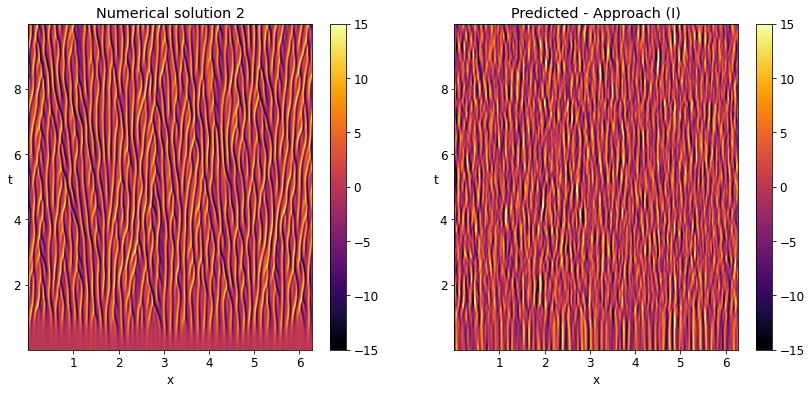

In [14]:
fig = plt.figure(figsize = [14,6])
X, T = np.meshgrid(x, t[1:])

for i in [i_test]:
    nn_input = u_final[i*m:(i+1)*m - 1,:]
    nn_output = u_final[i*m + 1:(i+1)*m,:]
    u_pred = nn_model.predict(nn_input)
    mse = np.mean(np.square(u_pred - nn_output))
    print('mse: ', mse)
    
    fig = plt.figure(figsize = [14,6])
    subplot(1,2,1)
    im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)
    plt.xlabel('x')
    plt.title('Numerical solution 2')
    plt.ylabel('t', rotation = 0)
    fig.colorbar(im)

    subplot(1,2,2)
    im = plt.pcolor(X, T, u_pred, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)
    plt.xlabel('x')
    plt.title('Predicted - Approach (I)')
    plt.ylabel('t', rotation = 0)
    fig.colorbar(im)
    plt.show()

## Approach II (recursive) - New IC : Advance solution from $t$ to $t + \Delta t$

mse:  61.566798578557226


C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/2819650373.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/2819650373.py:24: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = plt.pcolor(X, T, u_pred_rec, cmap='inferno', rasterized=True)


<Figure size 1008x432 with 0 Axes>

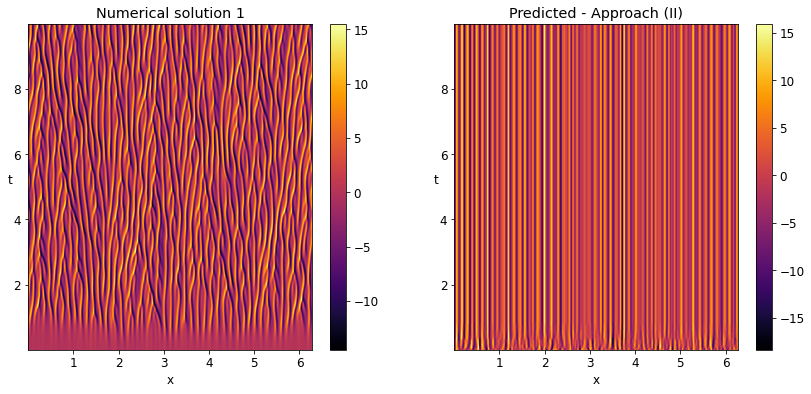

In [15]:
fig = plt.figure(figsize = [14,6])

for i in [i_test]:
    nn_input = u_final[i*m:(i+1)*m - 1,:]
    nn_output = u_final[i*m + 1:(i+1)*m,:]
    
    u_pred_rec = np.zeros(shape = (m,n))
    u_pred_rec[0,:] = nn_input[0,:]
    for i in range(1,m):
        u_pred_rec[i,:] = nn_model.predict(u_pred_rec[i-1,:].reshape(1,-1))
    u_pred_rec = u_pred_rec[1:,:]
    mse = np.mean(np.square(u_pred_rec - nn_output))
    print('mse: ', mse)
    
    fig = plt.figure(figsize = [14,6])
    subplot(1,2,1)
    im = plt.pcolor(X, T, nn_output, cmap='inferno', rasterized=True)
    plt.xlabel('x')
    plt.title('Numerical solution 1')
    plt.ylabel('t', rotation = 0)
    fig.colorbar(im)

    subplot(1,2,2)
    im = plt.pcolor(X, T, u_pred_rec, cmap='inferno', rasterized=True)
    plt.xlabel('x')
    plt.title('Predicted - Approach (II)')
    plt.ylabel('t', rotation = 0)
    fig.colorbar(im)
    plt.show()

## Forecast of future state
we re-train the NN model with training data consisting of the first numerical solution, but only up to time $\hat{T} = 5$.

In [16]:
KS_data = loadmat('KS_data.mat')
u = KS_data['uu']
x = KS_data['x'].flatten()
t = KS_data['t'].flatten()

dt = t[1] - t[0]
dx = x[2] - x[1]

n = len(x)
m = len(t)

m_half = int(m/2)

### Builid and train the NN model

In [17]:
#Prepare the data for the NN
nn_input = u[0:m_half-1,:]
nn_output = u[1:m_half,:]

nn_input_forward = u[m_half:-1,:]
nn_output_forward = u[m_half+1:,:]

In [18]:
# Set seed for reproducibility
np.random.seed(seed)
x_train, x_valid, y_train, y_valid = train_test_split(nn_input, nn_output, test_size = 0.1)

# Build model
nn_model = keras.models.Sequential()
nn_model.add(layers.Dense(2048, input_dim=2048, activation='tanh'))
nn_model.add(layers.Dense(1024, activation='tanh'))
nn_model.add(layers.Dense(2048, activation='linear'))

# Compile model
opt = keras.optimizers.Adam(learning_rate=0.01)
nn_model.compile(loss='mse', optimizer='adam')

# Fit!
if train:
    tf.random.set_seed(seed)
    History = nn_model.fit(x_train, y_train, epochs=1000, batch_size=50, validation_data=(x_valid, y_valid), callbacks=keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights= True))
else:
    # load json and create model
    json_file = open('./models/nn_KS_forward.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weights into new model
    nn_model.load_weights("./models/nn_KS_forward.h5")
    print("Loaded model from disk")

if save:
    # serialize model to JSON
    model_json = nn_model.to_json()
    with open("./nn_models_KS/models/nn_KS_forward.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    nn_model.save_weights("./models/nn_KS_forward.h5")
    print("Saved model to disk")

Loaded model from disk


## Approach I - Future forecast: Advance solution from $t$ to $t + \Delta t$

In [19]:
u_pred = nn_model.predict(nn_input)
print('mse: ', np.mean(np.square(u_pred - nn_output)))

mse:  0.10160452403832407


In [20]:
nn_input_plot = np.concatenate((nn_input, nn_input_forward))
nn_output_plot = np.concatenate((nn_output, nn_output_forward))

In [21]:
u_pred_forward = nn_model.predict(nn_input_plot)
print('mse: ', np.mean(np.square(u_pred_forward - nn_output_plot)))

mse:  20.77259743550982


### Plot:
The training range consists in the time-window below the white line at $\hat{T} = 5$.

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/1766112149.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, T, u_pred_forward, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)


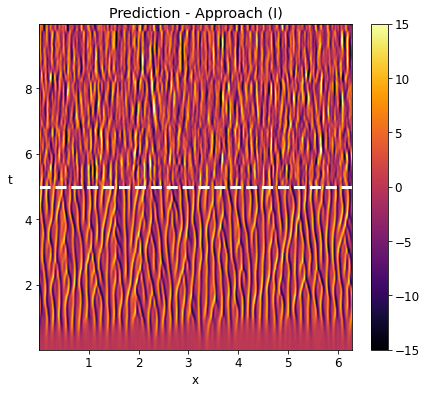

In [22]:
#Plot
X, T = np.meshgrid(x, t[1:-1])
fig, ax = plt.subplots(1,1)
im = ax.pcolormesh(X, T, u_pred_forward, cmap='inferno', rasterized=True, vmin = -15, vmax = 15)
plt.xlabel('x')
plt.axhline(y=5, linestyle = '--', color = 'white', linewidth = 3)
plt.title('Prediction - Approach (I)')
plt.ylabel('t', rotation = 0, labelpad = 15)
fig.colorbar(im)
#plt.savefig('./images/KS_forward.pdf',bbox_inches='tight', pad_inches=0.1)
plt.show()

C:\Users\paolo\AppData\Local\Temp/ipykernel_23016/915066230.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(X, T, np.abs(nn_output_plot - u_pred_forward), cmap='bwr', rasterized=True)#, vmax = 5)


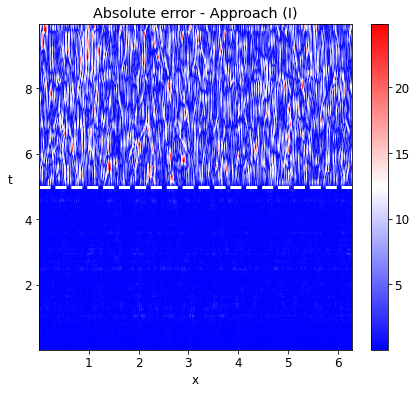

In [23]:
fig, ax = plt.subplots(1,1)
X, T = np.meshgrid(x, t[1:-1])
im = ax.pcolormesh(X, T, np.abs(nn_output_plot - u_pred_forward), cmap='bwr', rasterized=True)#, vmax = 5)
plt.axhline(y=5, linestyle = '--', color = 'white', linewidth = 3)
plt.xlabel('x')
plt.ylabel('t', rotation = 0, labelpad = 15)
plt.title('Absolute error - Approach (I)')
fig.colorbar(im)
#plt.savefig('./images/KS_forward_error.pdf',bbox_inches='tight', pad_inches=0.1)
plt.show()